In [10]:
import numpy as np
import matplotlib.pyplot as pyp
import sys
import os
import matplotlib
print sys.path.append(os.environ.get("TAU_ACC_DIR"))
import generate_electric_field_lookup_tables as efieldlut
import tau_Shower_Efield_Sim_lib as taulib
%matplotlib inline

None


In [11]:
pastel_colors = ['#FF6666','#FFCC66','#CCFF66','#66FF66','#66FFCC','#66FFFF','#66CCFF','#6666FF','#CC66FF','#FF66FF','#FF6FCF']
bright_colors = ['#FF0000','#FF8000','#FFFF00','#80FF00','#00FF00','#00FF80','#00FFFF','#0080FF','#0000FF','#8000FF','#FF00FF']
bright_colors2 = bright_colors = ['#FF0000','#FF8000','#80FF00','#00FF80','#0080FF','#0000FF','#8000FF','#FF00FF','#FF0080']
pyp.rcParams['font.size']=12
pyp.rcParams['legend.labelspacing'] = 0.1
cmap = matplotlib.cm.get_cmap('inferno')

In [27]:
###########################################################
def read_npz_files(antenna_height, zenith):
    #npzfile = np.load(os.environ['TAU_ACC_ZHAIRES_DIR'] + "/" + "altitude_%dkm_decay_%dkm_zenith_%d.npz"%(antenna_height, decay, zenith))
    npzfile = np.load(os.environ['TAU_ACC_ZHAIRES_DIR'] + "/0km_decay/" + "altitude_%dkm_zenith_%d.npz"%(antenna_height,zenith))

    efield_td = npzfile['efield_td'][()] ## for some reason just reading the arrays gives a 0-dim array, so skip this.
    efield_fd = npzfile['efield_fd'][()]
    return efield_td, efield_fd

In [30]:
def efield_vs_angle(h, decay, z, f_Lo_list, bandwidth):

    off_angle_array = np.arange(0.0,80*0.04, 0.04)
    i_off_angle_array = range(0, len(off_angle_array))
    epeak_list = np.zeros((len(f_Lo_list), len(i_off_angle_array)))
    cc = 0
    for i_offangle in i_off_angle_array:
        #if(i_offangle%10==0): print i_offangle
        offangle = off_angle_array[i_offangle]
        efield_td, efield_fd = read_npz_files(h, z)
        efield = efield_td[i_offangle]['y_v_per_m']
        time = efield_td[i_offangle]['time_s']
        time -= time[0]
        dt = np.abs(time[1]-time[0])
        E_fft = np.fft.rfft(efield)*dt*1.e6 # use dt in \mirco-s so that fft is in units of V/m/MHz
        fr = np.fft.rfftfreq(len(efield), dt*1.e6) # frequencies in MHz
        for i_f_Lo in range(0,len(f_Lo_list)):
            f_Lo = f_Lo_list[i_f_Lo]
            epeak_list[i_f_Lo, cc] = efieldlut.band_peak_efield(E_fft, fr, f_Lo, bandwidth)
        cc+=1
    return off_angle_array, epeak_list

In [31]:
###########################################################
# Construct an array of the peak efield for a range of starting frequencies
# and bandwidths and psi angles
def construct_epeak_array(h):
	zenith_list = np.array([55, 60, 65, 70, 75, 80, 85, 87, 89])
	f_Lo_list = np.arange(10., 1610., 10.)
	decay_list = np.arange(0., h, 0.5)
	bandwidth = 10.

	###
	# Construct an array of the peak efield for a range of starting frequencies
	# and bandwidths and psi angles
	## Shape of the array is 
	##  [zenith angle [55,65,60,70,75,80,85,87,89 starting_frequency (10-1600 MHz in 10 MHz steps), bandwidth (10 MHz), off_angles (0.04-3.2 in 0.04 deg steps)]

	epeak_array = []
	for z in zenith_list:
	    psi_list, epeak_list = efield_vs_angle(h, decay, z, f_Lo_list, bandwidth)
	    epeak_array.append(epeak_list)
	    
	epeak_array = np.array(epeak_array)

	return zenith_list, psi_list, f_Lo_list, epeak_array

In [39]:
# read CSV pulse files and calculate the frequency-domain peak electric field
altitude=3
decay = 0
zenith_list, psi_list, f_Lo_list, epeak_array = construct_epeak_array(altitude)

In [34]:
# read the interpolator file
EFIELD_LUT_filename = os.environ['TAU_ACC_ZHAIRES_DIR']\
		       +'/interpolator_efields_%dkm.npz'%(altitude)
efield_interpolator_list = efieldlut.load_efield_interpolator(EFIELD_LUT_filename)

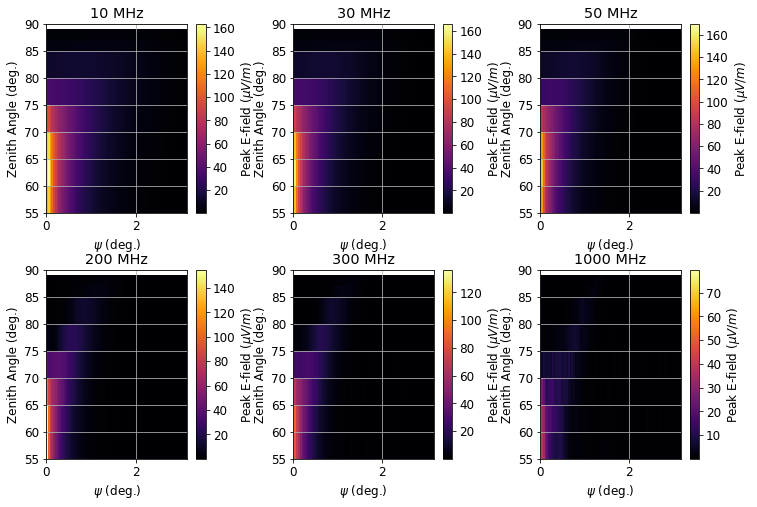

In [44]:
# compare the 2d histograms of epeak vs. zenith vs. psi
# to the interpolated plots
choose_start_freq = [10., 30., 50., 200., 300., 1000.]
efieldlut.plot_epeak_zenith_psi(altitude, decay, epeak_array, 
                                zenith_list, psi_list, choose_start_freq, log=False)


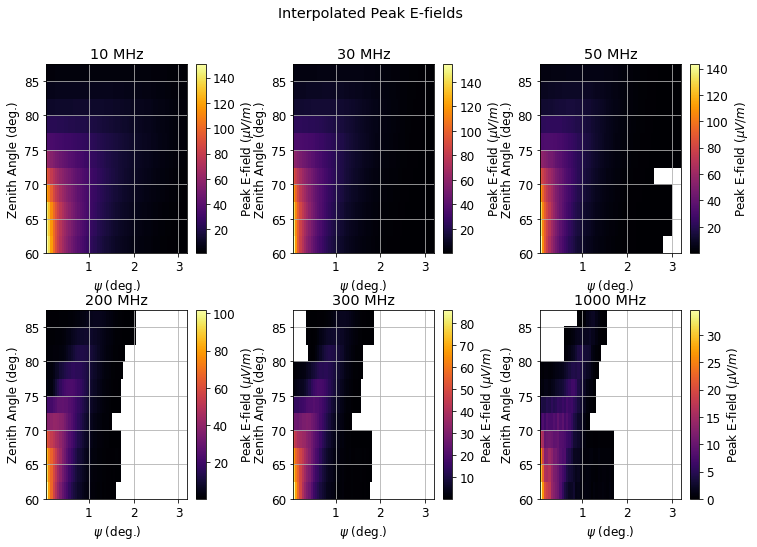

In [45]:
#choose_start_freq = [15., 35., 55., 205., 305., 1005.]
choose_start_freq = [10., 30., 50., 200., 300., 1000.]
efieldlut.plot_interp_zenith_psi(altitude, decay, efield_interpolator_list, choose_start_freq, log=False)

In [54]:
###########################################################
def epeak_zenith_angle_slice(i_ze, epeak_array):
    return epeak_array[i_ze,:, :] 
def epeak_start_freq_slice(i_f_Lo, epeak_array):
    return epeak_array[:,i_f_Lo,:] 
def epeak_psi_angle_slice(i_psi, epeak_array):
    return epeak_array[:,:,i_psi] 

In [67]:
def compare_1d_plots(h, epeak_array,efield_interpolator_list, zenith_list, psi_list, f_Lo_list, choose_ze, choose_f_Lo, log=False, plot_suffix="" ):

    pyp.figure(figsize=(14,4))
    pyp.subplots_adjust(hspace=0.3, wspace=0.5)
    pyp.subplot(1,2,1)

    #zenith_list = np.array([55,60,65,70,75,80,85,87,89])
    i_choose_ze = np.where(zenith_list==choose_ze)[0][0]
    epeak_zen = epeak_zenith_angle_slice(i_choose_ze, epeak_array)*1e6
    norm = matplotlib.colors.Normalize(vmin=-400, vmax=1600)
    for i_f_Lo in [1,3,7,9,26,34,67,100, 150]:
    	if( log):
		pyp.plot(psi_list, np.log10(epeak_zen[ i_f_Lo, :]), color = cmap(norm(f_Lo_list[i_f_Lo])), linewidth=2,
                	label="%d MHz"%(int(f_Lo_list[i_f_Lo])))
	else:
        	pyp.plot(psi_list,epeak_zen[ i_f_Lo, :], color = cmap(norm(f_Lo_list[i_f_Lo])), linewidth=2,
                	label="%d MHz"%(int(f_Lo_list[i_f_Lo])))
        #pyp.plot(psi_list, interpolator(87, f_Lo_list[i_f_Lo], psi_list)*1e6, color = cmap(norm(i_f_Lo)), linewidth=2)

    for i_f_Lo in np.array([1,3,7,9,26,34,67,100, 150]):
        if( log):
		pyp.plot(psi_list, np.log10(efield_interpolator_list[i_f_Lo](zenith_list[i_choose_ze], psi_list)*1e6), 'o',
                 color=cmap(norm(f_Lo_list[i_f_Lo])), label="%d MHz"%(int(f_Lo_list[i_f_Lo])))
	else:
		pyp.plot(psi_list, efield_interpolator_list[i_f_Lo](zenith_list[i_choose_ze], psi_list)*1e6, 'o',
                 color=cmap(norm(f_Lo_list[i_f_Lo])), label="%d MHz"%(int(f_Lo_list[i_f_Lo])))

    pyp.legend(loc=[1.01,0])
    pyp.xlabel(" $\psi$ (deg.)")
    if( log ):
    	pyp.ylabel("log(Peak E-field ($\mu V/m$))")
    else:
    	pyp.ylabel("Peak E-field ($\mu V/m$)")
        pyp.ylim(0,)


    pyp.xlim(psi_list.min(), psi_list.max())
    pyp.title("Zenith %d$^{\circ}$"%(int(zenith_list[i_choose_ze])))
    #pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/3dinterp_efield_maps_altitude%dkm_psi_ze%d.png"%(altitude, int(zenith_list[i_ze], )) )

    pyp.subplot(1,2,2)
    df = 10.
    i_choose_f_Lo = int(round(choose_f_Lo / df - 1))
    #print choose_f_Lo, i_choose_f_Lo, f_Lo_list[i_choose_f_Lo]
    epeak_zen = epeak_start_freq_slice(i_choose_f_Lo, epeak_array)*1e6
    norm = matplotlib.colors.Normalize(vmin=55, vmax=100)
    for i_ze, ze in enumerate(zenith_list):
    	if( log ):
		pyp.plot(psi_list, np.log10(epeak_zen[ i_ze, :]), color = cmap(norm(ze)), linewidth=3,
                 label="%d$^{\circ}$"%(int(ze)))
        else:
		pyp.plot(psi_list, epeak_zen[ i_ze, :], color = cmap(norm(ze)), linewidth=3,
                 label="%d$^{\circ}$"%(int(ze)))
    
    for i_ze,ze in enumerate(zenith_list):
        if( log):
		pyp.plot(psi_list,  np.log10(efield_interpolator_list[i_choose_f_Lo]( ze, psi_list,)*1e6), 'o',
                 color=cmap(norm(ze)),  label="%d$^{\circ}$"%(int(ze)))
	else:
		pyp.plot(psi_list,  efield_interpolator_list[i_choose_f_Lo]( ze, psi_list,)*1e6, 'o',
                 color=cmap(norm(ze)), label="%d$^{\circ}$"%(int(ze)))
    pyp.xlabel(" $\psi$ (deg.)")
    if( log ):
    	pyp.ylabel("log(Peak E-field ($\mu V/m$))")
    else:
    	pyp.ylabel("Peak E-field ($\mu V/m$)")
        pyp.ylim(0,)

    pyp.xlim(psi_list.min(), psi_list.max())
    pyp.legend(loc=[1.01, 0.1])
    pyp.title("%d MHz"%((int(f_Lo_list[i_choose_f_Lo]))))
#    pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + \
#                "/3dinterp_efield_maps_altitude%dkm_ze%d_psi_fLo%dMHz.png"%(h, choose_ze, choose_f_Lo)) 


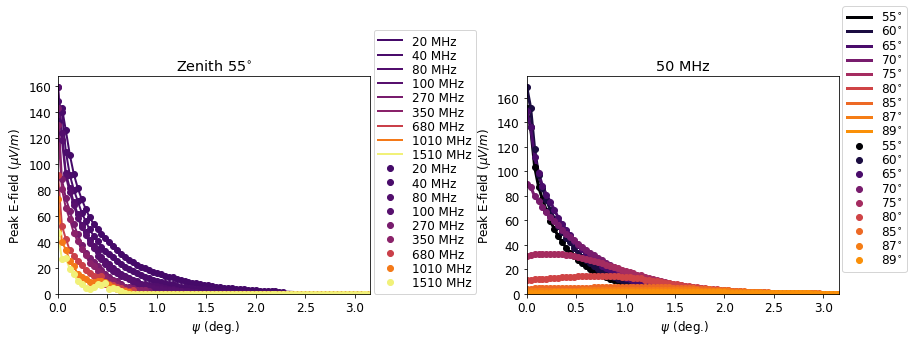

In [68]:
choose_ze = 55
choose_f_Lo = 50
compare_1d_plots( altitude,epeak_array, efield_interpolator_list, 
                           zenith_list, psi_list, f_Lo_list, choose_ze, choose_f_Lo, False)

In [38]:
def E_field_interp(efield_interpolator_list, view_angle_deg, zenith_angle_deg, f_Lo, f_High, log10_tau_energy, distance_exit_km, distance_decay_km):
    # Lorentzian beam pattern based on 10-MHz filtered subbands of Harm's results
    # Returns electric field peak in V/m
  
    # Since the efields are stored in 10-MHz subbands
    # integrate over the range from f_Lo to f_High in 10-MHz bands
    E_field = np.zeros(len(distance_decay_km))
    #E_field = 0.
    # TODO: Right now forcing the parameters outside the interpolation range to the edges
    # shoudl replace with extrapolation
    z = zenith_angle_deg.copy()
    v = view_angle_deg.copy()
    z[z>89.] = 89.
    z[z<55.] = 55.
    v[v<0.04] = 0.04
    v[v>3.16] = 3.16

    df = 10.
    for freq in np.arange(f_Lo, f_High, df):
        i_f_Lo = int(round(freq / df - 1))
        E_field += efield_interpolator_list[i_f_Lo](z,v) 
	
    # account for ZHAIReS sims only extending to 3.16 deg 
    #TODO: right now sampling a gaussian centered at zero to extrapolate to the wider angles. Should verify with ZHAireS sims out to wider angles
    E_field[view_angle_deg>3.16] = 0.

    E_field *= distance_exit_km/distance_decay_km   # distance to tau decay point correction
    E_field *= 10**(log10_tau_energy - 17.) # Energy scaling
    return E_field
####################################################################################